In [1]:
import pandas as pd

# Load the CSV file
file_path = '../cab_rides.csv'
cab_rides_df = pd.read_csv(file_path)

In [2]:
# Display the column names
cab_rides_df.columns.tolist()

['distance',
 'cab_type',
 'time_stamp',
 'destination',
 'source',
 'price',
 'surge_multiplier',
 'id',
 'product_id',
 'name']

In [3]:
# 필터링 및 데이터 전처리
lyft_rides = cab_rides_df[(cab_rides_df['product_id'] == 'lyft') & (cab_rides_df['source'] == 'Haymarket Square')]

# time_stamp를 인덱스로 설정하고 필요한 컬럼만 선택
lyft_rides.set_index('time_stamp', inplace=True)
# index를 정렬
lyft_rides.sort_index(inplace=True)
lyft_rides = lyft_rides[['distance', 'price', 'surge_multiplier']]

lyft_rides.head()

/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_64819/3461874122.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyft_rides.sort_index(inplace=True)


,distance,price,surge_multiplier
time_stamp,,,
1543207256893,0.91,7.0,1.0
1543207398281,0.65,7.0,1.0
1543207399857,0.64,9.0,1.0
1543208581838,1.95,9.0,1.0
1543209240907,1.32,7.0,1.0


In [4]:
lyft_rides['surge_multiplier'].value_counts()

surge_multiplier
1.00    4187
1.25      64
1.50      17
1.75       1
Name: count, dtype: int64

In [27]:
import pymc3 as pm
import numpy as np
import theano.tensor as tt

def estimate_demand_parameters(dataframe, price_col):
    """
    Estimates the demand parameters (eta, a, b) using PyMC3 and adds them as new columns in the dataframe.

    :param dataframe: Pandas DataFrame containing the data
    :param price_col: Name of the column containing price data
    :return: DataFrame with new columns for eta, a, b estimates
    """
    with pm.Model() as model:
        # Define priors
        eta = pm.Normal('eta', mu=0.25, sd=0.1)
        a = pm.Uniform('a', lower=0, upper=1)
        b = pm.Uniform('b', lower=0, upper=20)

        # Convert the price data to a theano tensor
        price_data = tt.as_tensor_variable(dataframe[price_col].values)

        surge_multiplier_data = tt.as_tensor_variable(dataframe['surge_multiplier'].values)
        # Define the demand function using pm.math.exp for exponentiation
        demand = a * pm.math.exp(-tt.abs_(eta) * tt.log(price_data)) + b

        # Assuming Gaussian noise in the observed data
        observed = pm.Normal('observed', mu=demand, sd=1, observed=dataframe[price_col])

        # Sample from the posterior
        trace = pm.sample(1000, tune=1000, return_inferencedata=False)

    # Extracting the mean of the posterior distributions
    eta_mean = np.mean(trace['eta'])
    a_mean = np.mean(trace['a'])
    b_mean = np.mean(trace['b'])

    # Adding new columns to the dataframe
    dataframe['estimated_eta'] = eta_mean
    dataframe['estimated_a'] = a_mean
    dataframe['estimated_b'] = b_mean

    return dataframe, trace


In [28]:
updated_df, trace = estimate_demand_parameters(lyft_rides, 'price')
updated_df.head()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6989736292193823, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,distance,price,surge_multiplier,estimated_eta,estimated_a,estimated_b
time_stamp,,,,,,
1543207256893,0.91,7.0,1.0,0.207578,0.012948,7.638423
1543207398281,0.65,7.0,1.0,0.207578,0.012948,7.638423
1543207399857,0.64,9.0,1.0,0.207578,0.012948,7.638423
1543208581838,1.95,9.0,1.0,0.207578,0.012948,7.638423
1543209240907,1.32,7.0,1.0,0.207578,0.012948,7.638423


In [32]:
import matplotlib.pyplot as plt

def plot_demand_estimations(trace, prices, dataframe):
    etas = trace['eta']
    as_ = trace['a']
    bs = trace['b']

    plt.figure(figsize=(10, 6))
    
    # 각 샘플에 대한 수요 함수 계산 및 시각화
    for eta_sample, a_sample, b_sample in zip(etas, as_, bs):
        # 여기서 surge_multiplier_data를 평균값 또는 특정 값으로 사용
        surge_multiplier_mean = np.mean(dataframe['surge_multiplier'].values)
        demand_sample = a_sample * np.power(prices, -np.abs(eta_sample)) + b_sample
        plt.plot(prices, demand_sample, color='grey', alpha=0.1)  # 투명한 회색으로 표시

    # 최종 추정된 함수 표시 (평균 값 사용)
    eta_mean = np.mean(trace['eta'])
    a_mean = np.mean(trace['a'])
    b_mean = np.mean(trace['b'])

    # surge_multiplier_data에 대한 평균 또는 특정 값 사용
    surge_multiplier_mean = np.mean(dataframe['surge_multiplier'].values)
    demand = a_mean * np.power(prices, -np.abs(eta_mean)) + b_mean
    plt.plot(prices, demand, color='blue', label='Estimated Demand Function')  # 파란색으로 표시

    # 차트 설정
    plt.xlabel('Price')
    plt.ylabel('Demand')
    plt.title('Demand Function Estimations')
    plt.legend()
    plt.grid(True)
    plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


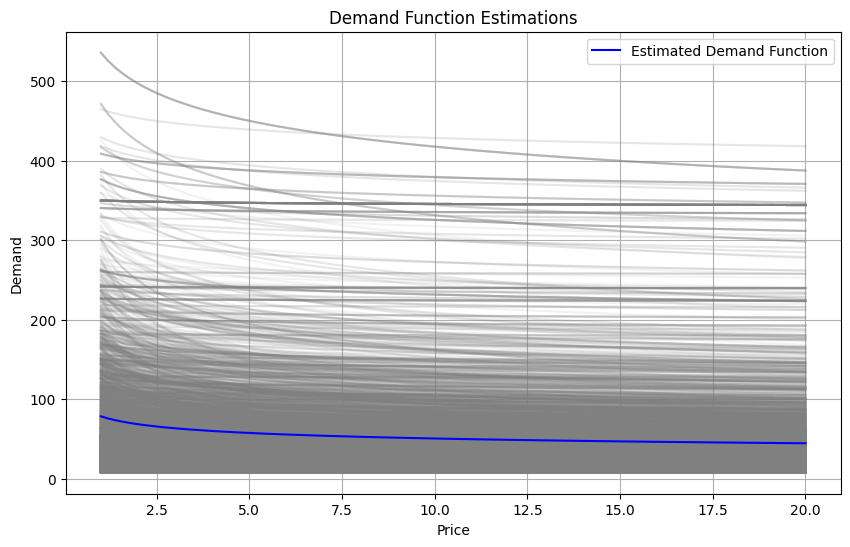

In [30]:
updated_df, trace = estimate_demand_parameters(lyft_rides, 'price')
prices = np.linspace(1, 20, 100)
plot_demand_estimations(trace, prices, updated_df)

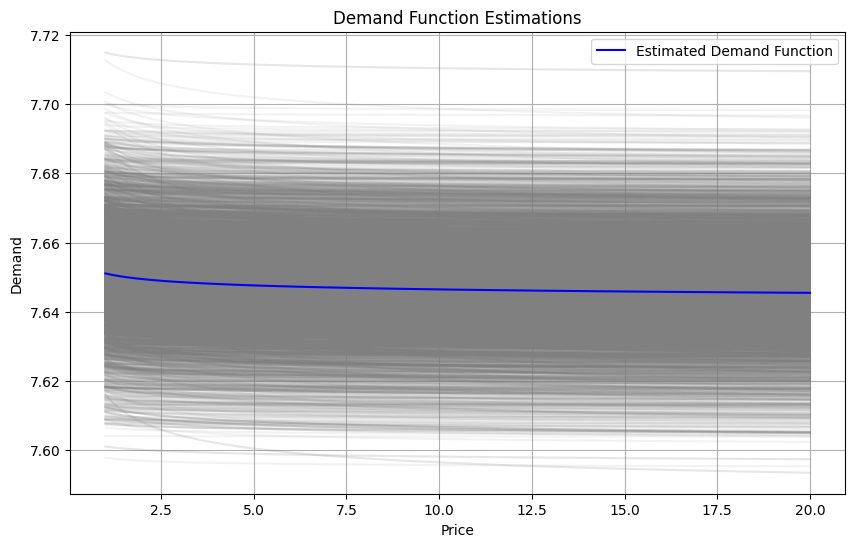

In [33]:
prices = np.linspace(1, 20, 100)
plot_demand_estimations(trace, prices, updated_df)

In [18]:
updated_df.head()

,distance,price,surge_multiplier,estimated_eta,estimated_a,estimated_b
time_stamp,,,,,,
1543207256893,0.91,7.0,1.0,0.000154,0.981957,6.661729
1543207398281,0.65,7.0,1.0,0.000154,0.981957,6.661729
1543207399857,0.64,9.0,1.0,0.000154,0.981957,6.661729
1543208581838,1.95,9.0,1.0,0.000154,0.981957,6.661729
1543209240907,1.32,7.0,1.0,0.000154,0.981957,6.661729
